In [1]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

import matplotlib.pyplot as plt
fs = pa.hdfs.connect()

<ipython-input-1-1f01dbbf49b8>:7: DeprecationWarning: pyarrow.hdfs.connect is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  fs = pa.hdfs.connect()


In [2]:
def annot_max(x, y, ax=None, time_quantum="days"):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "x={:.3f}, y={:.3f}".format(xmax, ymax) 
    text = f"x={xmax:.3f}, y={ymax:.3f}, (period: {(1./xmax):.2f} {time_quantum})"
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60")
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax),  xytext=(0.94, 0.96), **kw)

In [3]:
df = pq.ParquetDataset("/data/Archive/bhavesh/InventoryPrediction/temp/highErrorQueriesDailyQuantity", fs).read().to_pandas()
df.head()

,similargrouplevel,query,date,quantity
0,830303011,avaasa_#_#_1_#_straight,2023-03-10,7216
1,830216013,#_#_check_#_#_#,2022-12-17,14057
2,830216013,#_#_check_#_full-length sleeve_#,2022-11-04,9269
3,830216013,#_#_#_#_#_classic,2023-04-23,46105
4,830216013,#_#_#_#_full-length sleeve_classic,2023-04-29,40828


In [4]:
df1 = df[(df["similargrouplevel"] == 830303011) & (df["query"] == "avaasa_#_#_1_#_straight")].copy()[["date", "quantity"]]
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 516 entries, 0 to 5149
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      516 non-null    object
 1   quantity  516 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ KB


In [5]:
df1 = df1.sort_values(by="date").reset_index(drop=True)
df1["date"] = df1["date"].astype(str)
df1

,date,quantity
0,2022-01-01,3033
1,2022-01-02,3976
2,2022-01-03,4412
3,2022-01-04,7437
4,2022-01-05,5851
...,...,...
511,2023-05-27,6154
512,2023-05-28,11014
513,2023-05-29,2242
514,2023-05-30,4182


### Daily Fourier transform

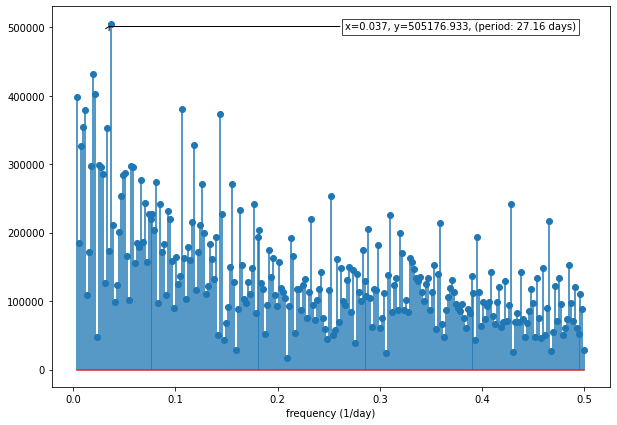

In [6]:
daily_data = df1.copy()
nobs = len(daily_data['quantity'])
quantity_ft = np.abs(np.fft.rfft(daily_data['quantity']))
quantity_freq = np.fft.rfftfreq(nobs)

plt.figure(figsize=(10, 7))
plt.stem(quantity_freq[2:], quantity_ft[2: ])
annot_max(quantity_freq[2:], quantity_ft[2: ])
    
plt.xlabel('frequency (1/day)')
plt.show()

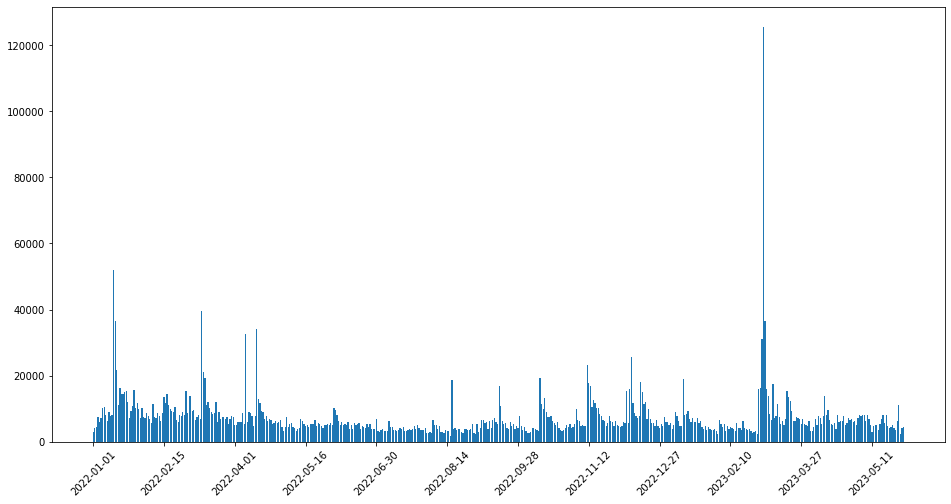

In [7]:
label_indices = np.arange(0, len(daily_data.date), 45)
plt.figure(figsize=(16, 8))
plt.bar(daily_data.date, daily_data.quantity)
plt.xticks(daily_data.date.iloc[label_indices],rotation=45)
plt.show()

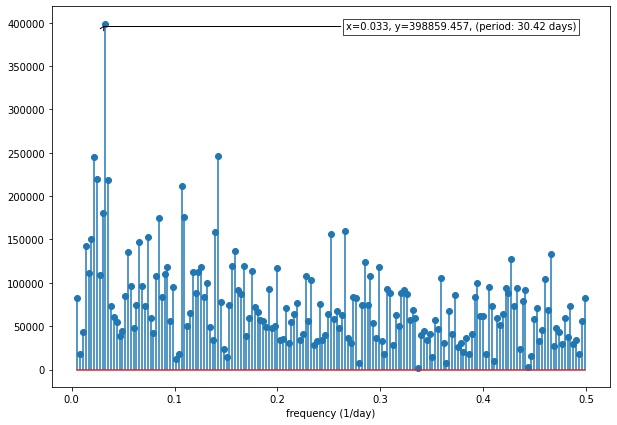

In [8]:
daily_data = df1.copy()
daily_data["year"] = daily_data["date"].str[:4].astype(int)
daily_data = daily_data[daily_data["year"] == 2022].drop(columns=["year"])
nobs = len(daily_data['quantity'])
quantity_ft = np.abs(np.fft.rfft(daily_data['quantity']))
quantity_freq = np.fft.rfftfreq(nobs)

plt.figure(figsize=(10, 7))
plt.stem(quantity_freq[2:], quantity_ft[2: ])
annot_max(quantity_freq[2:], quantity_ft[2: ])
    
plt.xlabel('frequency (1/day)')
plt.show()

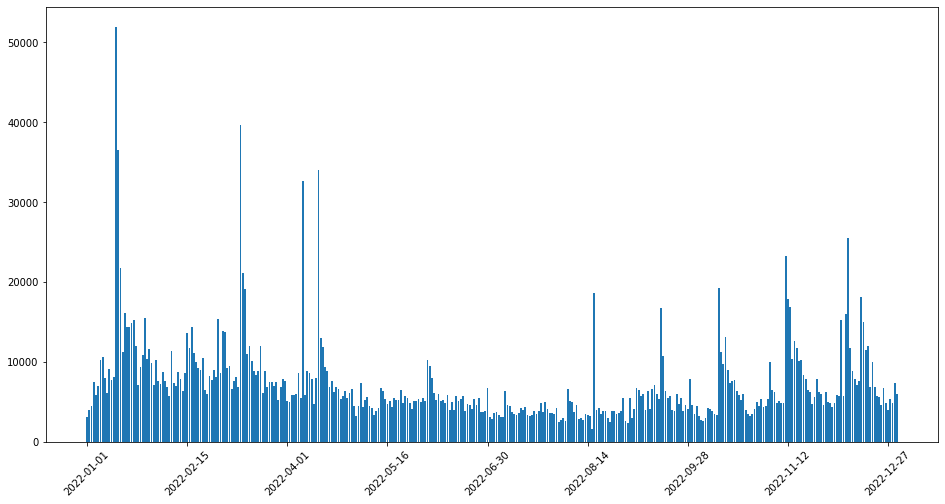

In [9]:
label_indices = np.arange(0, len(daily_data.date), 45)
plt.figure(figsize=(16, 8))
plt.bar(daily_data.date, daily_data.quantity)
plt.xticks(daily_data.date.iloc[label_indices],rotation=45)
plt.show()

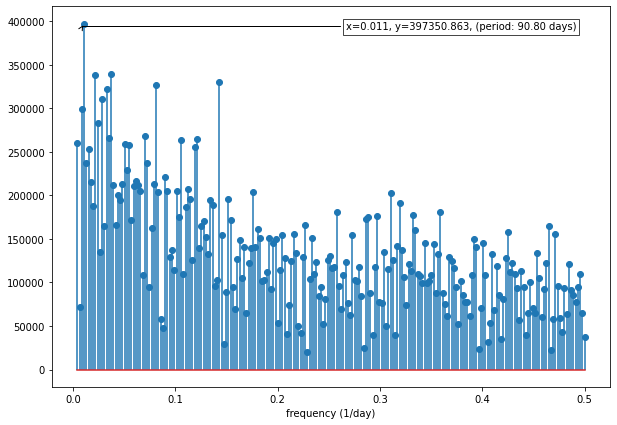

In [10]:
daily_data = df1.copy()
daily_data = daily_data[daily_data["date"] >= "2022-02-01"]
daily_data = daily_data[daily_data["date"] < "2023-05-01"]
nobs = len(daily_data['quantity'])
quantity_ft = np.abs(np.fft.rfft(daily_data['quantity']))
quantity_freq = np.fft.rfftfreq(nobs)

plt.figure(figsize=(10, 7))
plt.stem(quantity_freq[2:], quantity_ft[2: ])
annot_max(quantity_freq[2:], quantity_ft[2: ])
    
plt.xlabel('frequency (1/day)')
plt.show()

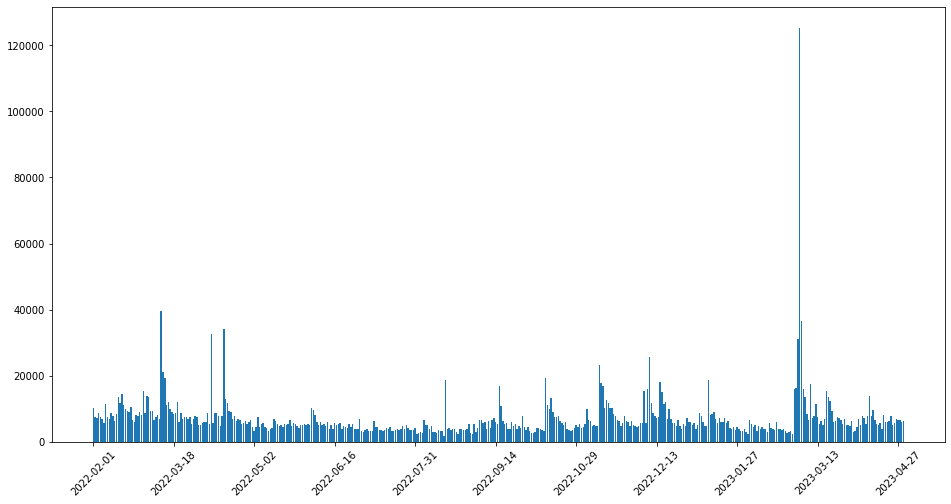

In [11]:
label_indices = np.arange(0, len(daily_data.date), 45)
plt.figure(figsize=(16, 8))
plt.bar(daily_data.date, daily_data.quantity)
plt.xticks(daily_data.date.iloc[label_indices],rotation=45)
plt.show()

### Understanding fourier analysis

In [12]:
dates = df1[df1["date"] < "2023-01-01"].date.values

#### Straight line

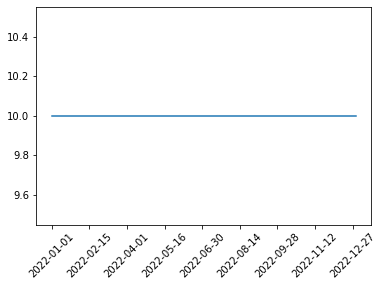

In [13]:
data = pd.DataFrame({"date": dates, "quantity": 10})
label_indices = np.arange(0, len(data.date), 45)
plt.plot(data.date, data.quantity)
plt.xticks(data.date.iloc[label_indices],rotation=45)
plt.show()

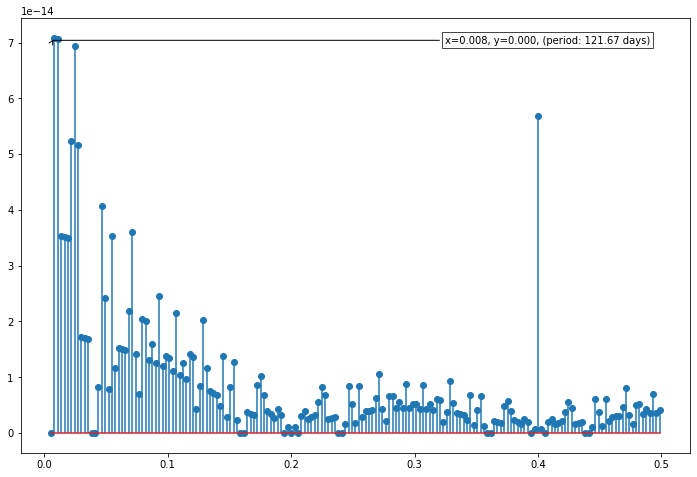

In [14]:
nobs = len(data['quantity'])
quantity_ft = np.abs(np.fft.rfft(data['quantity']))
quantity_freq = np.fft.rfftfreq(nobs, 1)

plt.figure(figsize=(12, 8))
plt.stem(quantity_freq[2:], quantity_ft[2: ])
annot_max(quantity_freq[2:], quantity_ft[2: ])
    
plt.show()

#### Increasing quantity

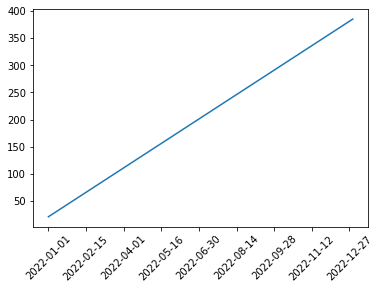

In [15]:
data = pd.DataFrame({"date": dates, "quantity": 20 + np.arange(1, len(dates) + 1)})
label_indices = np.arange(0, len(data.date), 45)
plt.plot(data.date, data.quantity)
plt.xticks(data.date.iloc[label_indices],rotation=45)
plt.show()

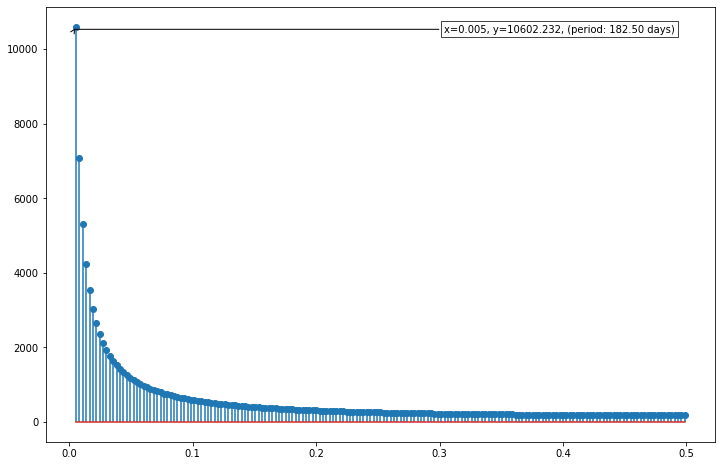

In [16]:
nobs = len(data['quantity'])
quantity_ft = np.abs(np.fft.rfft(data['quantity']))
quantity_freq = np.fft.rfftfreq(nobs, 1)

plt.figure(figsize=(12, 8))
plt.stem(quantity_freq[2:], quantity_ft[2: ])
annot_max(quantity_freq[2:], quantity_ft[2: ])
    
# plt.xlabel('frequency (1/day)')
plt.show()

#### Decreasing quantity

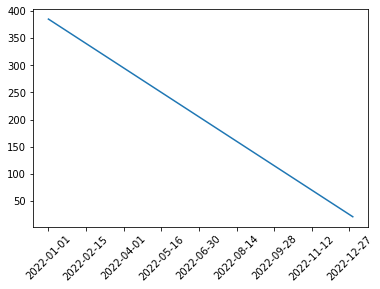

In [17]:
data = pd.DataFrame({"date": dates, "quantity": 20 + np.array(range(len(dates), 0, -1))})
label_indices = np.arange(0, len(data.date), 45)
plt.plot(data.date, data.quantity)
plt.xticks(data.date.iloc[label_indices],rotation=45)
plt.show()

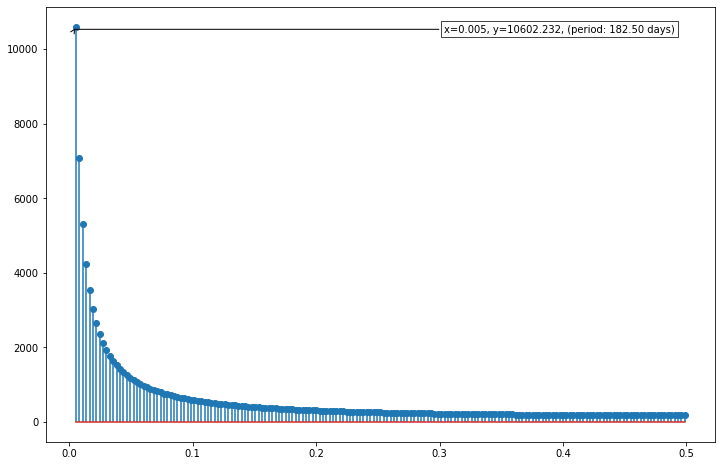

In [18]:
nobs = len(data['quantity'])
quantity_ft = np.abs(np.fft.rfft(data['quantity']))
quantity_freq = np.fft.rfftfreq(nobs, 1)

plt.figure(figsize=(12, 8))
plt.stem(quantity_freq[2:], quantity_ft[2: ])
annot_max(quantity_freq[2:], quantity_ft[2: ])
    
# plt.xlabel('frequency (1/day)')
plt.show()

#### Sine wave with slope 0

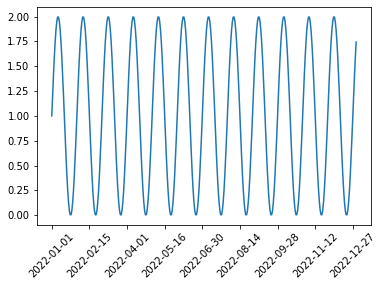

In [19]:
f = 1/30
fs = 1
t = 365
samples = np.arange(t*fs)/fs
data = pd.DataFrame({"date": dates, "quantity": 1 + np.sin(2*np.pi*f*samples)})
label_indices = np.arange(0, len(data.date), 45)
plt.plot(data.date, data.quantity)
plt.xticks(data.date.iloc[label_indices],rotation=45)
plt.show()

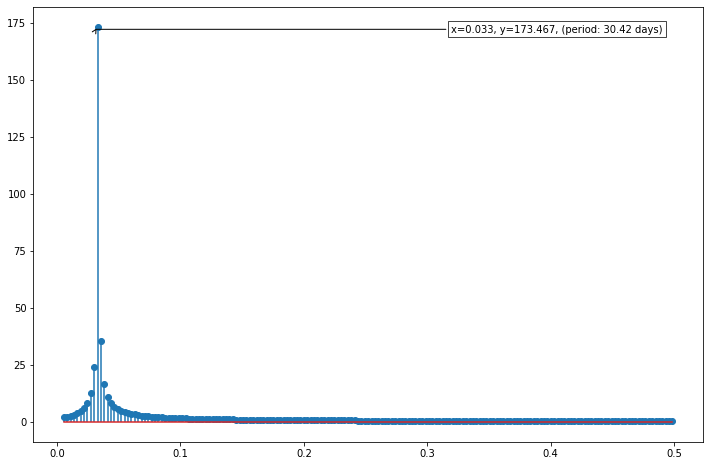

In [20]:
nobs = len(data['quantity'])
quantity_ft = np.abs(np.fft.rfft(data['quantity']))
quantity_freq = np.fft.rfftfreq(nobs, 1)

plt.figure(figsize=(12, 8))
plt.stem(quantity_freq[2:], quantity_ft[2: ])
annot_max(quantity_freq[2:], quantity_ft[2: ])
    
# plt.xlabel('frequency (1/day)')
plt.show()

#### Sine wave with different frequency

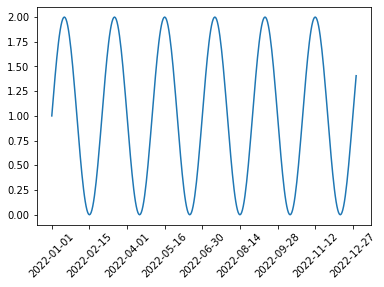

In [21]:
f = 1/60
fs = 1
t = 365
samples = np.arange(t*fs)/fs
data = pd.DataFrame({"date": dates, "quantity": 1+np.sin(2*np.pi*f*samples)})
label_indices = np.arange(0, len(data.date), 45)
plt.plot(data.date, data.quantity)
plt.xticks(data.date.iloc[label_indices],rotation=45)
plt.show()

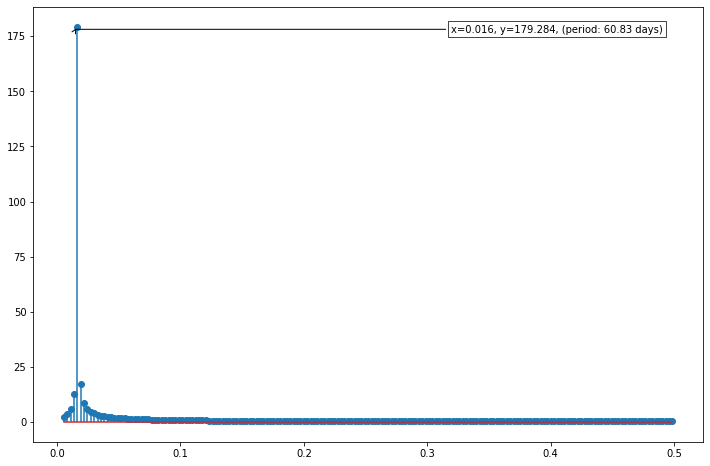

In [22]:
nobs = len(data['quantity'])
quantity_ft = np.abs(np.fft.rfft(data['quantity']))
quantity_freq = np.fft.rfftfreq(nobs, 1)

plt.figure(figsize=(12, 8))
plt.stem(quantity_freq[2:], quantity_ft[2: ])
annot_max(quantity_freq[2:], quantity_ft[2: ])
    
# plt.xlabel('frequency (1/day)')
plt.show()

#### 1.5 sin wave

In [23]:
f = 1/60
fs = 1
t = 365
samples = np.arange(t*fs)/fs

In [24]:
y = np.sin(2*np.pi*f*samples)

In [25]:
r = 0
for idx, i in enumerate(y):
    if i<0:
        y[idx] = y[idx] * -1
prev_prev = -0.01
prev = 0
cnt = 1
arr = [0]
for idx, i in enumerate(y[1:]):
    if i > prev and prev_prev > prev:
        cnt += 1
    if cnt % 3 == 0 and cnt!=0:
        arr.append(i * -1)
    else:
        arr.append(i)
    prev, prev_prev = i, prev
arr = np.array(arr) + 1

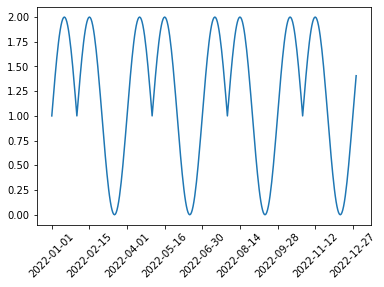

In [26]:
data = pd.DataFrame({"date": dates, "quantity": arr})
label_indices = np.arange(0, len(data.date), 45)
plt.plot(data.date, data.quantity)
plt.xticks(data.date.iloc[label_indices],rotation=45)
plt.show()

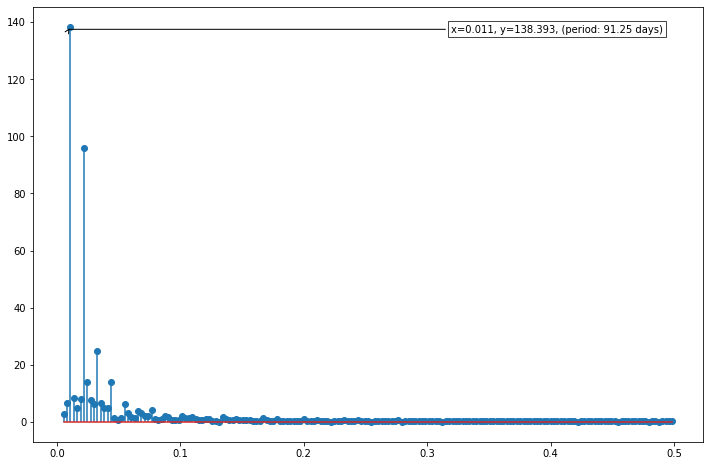

In [27]:
nobs = len(data['quantity'])
quantity_ft = np.abs(np.fft.rfft(data['quantity']))
quantity_freq = np.fft.rfftfreq(nobs, 1)

plt.figure(figsize=(12, 8))
plt.stem(quantity_freq[2:], quantity_ft[2: ])
annot_max(quantity_freq[2:], quantity_ft[2: ])
    
# plt.xlabel('frequency (1/day)')
plt.show()